In [ ]:
!cat /root/.kaggle/kaggle.json

In [ ]:
!pip install -q transformers

In [ ]:
import torch
from transformers import ViTFeatureExtractor, ViTForImageClassification
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
from PIL import Image

In [ ]:
model_checkpoint = "facebook/convnextv2-base-22k-224"

In [ ]:
import os

In [ ]:
!ls

In [ ]:
!pwd

In [ ]:
!pip install -Uq datasets 

In [ ]:
import os  # Import the os module

# Now you can use os.path.join() function
trainpath = os.path.join("/kaggle/working/data/test-train/WCEBleedGen/Train_Test_Folder/train",'**')


In [ ]:
testpath=  os.path.join("/kaggle/working/data/test-train/WCEBleedGen/Train_Test_Folder/test","**")

In [ ]:
from datasets import load_dataset 
dataset = load_dataset("imagefolder", data_files={"train": trainpath, "test": testpath})

In [ ]:
dataset

In [ ]:
dataset["train"].features

In [ ]:
example = dataset["train"][0]

In [ ]:
example['image']

In [ ]:
example['image'].resize((200, 200))

In [ ]:
dataset["train"].features["label"]
labels = dataset["train"].features["label"].names

In [ ]:
print(labels) 

In [ ]:
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[1]

In [ ]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

In [ ]:

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [ ]:
train_ds = dataset['train']

In [ ]:
test_ds = dataset['test']

In [ ]:
train_ds.set_transform(preprocess_train)
test_ds.set_transform(preprocess_val)

In [ ]:
train_ds[0]

In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

In [ ]:
batch_size=16

In [ ]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-BASE",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=1,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    logging_steps=10,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

In [ ]:
from datasets import list_metrics

In [ ]:
list_metrics()

In [ ]:
from datasets import load_metric

metric1 = load_metric("accuracy")
metric2 = load_metric("recall")
metric3 = load_metric("f1")

In [ ]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    accuracy = metric1.compute(predictions=predictions, references=labels)['accuracy']
    recall = metric2.compute(predictions=predictions, references=labels)['recall']
    f1 = metric3.compute(predictions=predictions, references=labels)['f1']
    return {"accuracy": accuracy,"recall": recall, "f1": f1}

In [ ]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [ ]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

In [ ]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

In [ ]:
!mkdir data

In [ ]:
!cp -r "/kaggle/input/test-train" data/

In [ ]:
import os
x=os.listdir("/kaggle/working/data/test-train/WCEBleedGen/Train_Test_Folder/test/bleeding")

In [ ]:
y= x[:10]

In [ ]:
y

In [ ]:
!cp "/kaggle/working/data/test-train/WCEBleedGen/Train_Test_Folder/test/bleeding/img- (853).png" . 
!cp "/kaggle/working/data/test-train/WCEBleedGen/Train_Test_Folder/test/bleeding/img- (1046).png" . 
!cp "/kaggle/working/data/test-train/WCEBleedGen/Train_Test_Folder/test/bleeding/img- (609).png" . 
!cp "/kaggle/working/data/test-train/WCEBleedGen/Train_Test_Folder/test/bleeding/img- (1134).png" . 
!cp "/kaggle/working/data/test-train/WCEBleedGen/Train_Test_Folder/test/bleeding/img- (262).png" .
!cp "/kaggle/working/data/test-train/WCEBleedGen/Train_Test_Folder/test/bleeding/img- (539).png" . 
!cp "/kaggle/working/data/test-train/WCEBleedGen/Train_Test_Folder/test/bleeding/img- (812).png" . 
!cp "/kaggle/working/data/test-train/WCEBleedGen/Train_Test_Folder/test/bleeding/img- (612).png" . 
!cp "/kaggle/working/data/test-train/WCEBleedGen/Train_Test_Folder/test/bleeding/img- (1256).png" . 
!cp "/kaggle/working/data/test-train/WCEBleedGen/Train_Test_Folder/test/bleeding/img- (234).png" . 

In [ ]:
for i in y:
    os.remove("/kaggle/working/data/test-train/WCEBleedGen/Train_Test_Folder/test/bleeding/"+i)

In [ ]:
from transformers import pipeline

In [ ]:
from PIL import Image

In [ ]:
import requests

In [ ]:
image = Image.open("/kaggle/working/img- (234).png")

In [ ]:
pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/cu111/torch_stable.html


In [ ]:
pipe = pipeline("image-classification", 
                model=model,
                feature_extractor=image_processor, device=0)

In [ ]:
pipe(image)

In [ ]:
from transformers import AutoConfig, AutoModelForImageClassification, AutoImageProcessor

In [ ]:
config = AutoConfig.from_pretrained("/kaggle/working/convnextv2-atto-1k-224-ATTO/checkpoint-198/config.json")

In [ ]:
model = AutoModelForImageClassification.from_pretrained(
    "/kaggle/working/convnextv2-atto-1k-224-ATTO/checkpoint-198/", config=config
)

In [ ]:
image_processor  = AutoImageProcessor.from_pretrained("/kaggle/working/convnextv2-atto-1k-224-ATTO/checkpoint-198/")

In [ ]:
from PIL import Image
image = Image.open("/kaggle/working/data/test-train/WCEBleedGen/Images/bleeding/img- (1248).png")

In [ ]:
encoding = image_processor(image.convert("RGB"), return_tensors="pt").to("cuda")


In [ ]:
encoding

In [ ]:
import torch

# forward pass
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

In [ ]:
logits

In [ ]:
torch.nn.functional.softmax(logits, dim=1)[0, 0]

In [ ]:
predicted_class_idx = logits.argmax(-1).item()

In [ ]:
predicted_class_idx

In [ ]:
model.config.id2label

In [ ]:
logits.argsort()[0][-5:]

In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

In [ ]:
!pip install omnixai

In [1]:
!pip install lime

In [7]:
!pip uninstall numpy -y

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5


In [ ]:
!python3 -m pip install scikit-learn==1.1.3

In [14]:
import scipy

In [ ]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

In [18]:
print(scipy.__version__)

1.7.3


In [ ]:
pipe = pipeline("image-classification", 
                model=model,
                feature_extractor=image_processor)

In [ ]:
temp_images = [Image.open("/kaggle/working/data/test-train/WCEBleedGen/Images/bleeding/img- (1248).png"), Image.open("/kaggle/working/data/test-train/WCEBleedGen/Images/bleeding/img- (1248).png")]

In [ ]:
pipe([Image.open("/kaggle/working/data/test-train/WCEBleedGen/Images/bleeding/img- (1248).png"), Image.open("/kaggle/working/data/test-train/WCEBleedGen/Images/bleeding/img- (1248).png")])

In [ ]:
def batchpredict(images):
    batch = [image_processor(img, return_tensors="pt") for img in images]
    with torch.no_grad():
        outputs = [model(**b) for b in batch]
        logits = [torch.nn.functional.softmax(o.logits, dim=1) for o in outputs]
        return torch.cat(logits).detach().cpu().numpy()

In [ ]:
batchpredict(temp_images)

In [ ]:
for x in batchpredict(temp_images).argsort()[0][-5:]:
    print( x, model.config.id2label[x], batchpredict(temp_images)[0,x])

In [294]:
import numpy as np
limetestimage = [np.array(Image.open("/kaggle/input/testbleedyolo/Auto-WCEBleedGen Challenge Test Dataset/Test Dataset 1/A0040.png").convert('RGB'), )]

In [ ]:
limetestimage.shape = (224, 224, 3)

In [295]:
explanation = explainer.explain_instance(limetestimage, batchpredict, top_labels=2, hide_color=0, num_samples=1000)


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
from skimage.segmentation import mark_boundaries


In [ ]:
import matplotlib.pyplot as plt
temp, mask = explanation.get_image_and_mask(0, positive_only=True, num_features=2, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
import matplotlib.pyplot as plt
temp, mask = explanation.get_image_and_mask(1, positive_only=True, num_features=2, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
Image.open("/kaggle/working/data/test-train/WCEBleedGen/Images/bleeding/img- (1069).png")

In [ ]:
temp, mask = explanation.get_image_and_mask(0, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [15]:
test1dict = {}
def predict(images):
    encoding = image_processor(images.convert("RGB"), return_tensors="pt")
    with torch.no_grad():
        outputs = model(**encoding) 
        logits = outputs.logits
        prob = torch.nn.functional.softmax(logits, dim=1)
        test1dict[images.filename.split('/')[-1]] = [model.config.id2label[logits.argmax(-1).item()], prob.detach().cpu().squeeze().tolist()]
        return 0

In [16]:
import os
from PIL import Image
import torch
z = os.listdir("/kaggle/input/testbleedyolo/Auto-WCEBleedGen Challenge Test Dataset/Test Dataset 1/")
for a in z:
    img = Image.open("/kaggle/input/testbleedyolo/Auto-WCEBleedGen Challenge Test Dataset/Test Dataset 1/"+a)
    predict(img)

In [17]:
test1dict

{'A0028.png': ['non-bleeding', [0.00656186742708087, 0.9934380650520325]],
 'A0016.png': ['non-bleeding', [0.0008446004940196872, 0.9991554021835327]],
 'A0046.png': ['non-bleeding', [0.0240397397428751, 0.9759603142738342]],
 'A0041.png': ['non-bleeding', [0.0008005812996998429, 0.9991994500160217]],
 'A0023.png': ['non-bleeding', [0.027021873742341995, 0.9729781746864319]],
 'A0042.png': ['bleeding', [0.9985209107398987, 0.0014791081193834543]],
 'A0038.png': ['bleeding', [0.9861766695976257, 0.013823379762470722]],
 'A0007.png': ['non-bleeding', [0.05690043047070503, 0.9430996179580688]],
 'A0044.png': ['non-bleeding', [0.001440991647541523, 0.9985590577125549]],
 'A0002.png': ['bleeding', [0.9997251629829407, 0.00027481705183163285]],
 'A0040.png': ['bleeding', [0.9803436994552612, 0.019656337797641754]],
 'A0019.png': ['non-bleeding', [0.001256388146430254, 0.9987435936927795]],
 'A0021.png': ['non-bleeding', [0.41142430901527405, 0.5885757207870483]],
 'A0037.png': ['bleeding', [

In [ ]:
Image.open("/kaggle/input/testbleedyolo/Auto-WCEBleedGen Challenge Test Dataset/Test Dataset 1/A0034.png")

In [20]:
def custom_sort_key(item):
    return max(item[1][1])
sorted_dict1 = dict(sorted(test1dict.items(), key=custom_sort_key, reverse=True))
print(sorted_dict1)

{'A0049.png': ['non-bleeding', [0.000119657204777468, 0.999880313873291]], 'A0034.png': ['bleeding', [0.9998767375946045, 0.0001232947106473148]], 'A0000.png': ['bleeding', [0.9997746348381042, 0.0002254223800264299]], 'A0002.png': ['bleeding', [0.9997251629829407, 0.00027481705183163285]], 'A0048.png': ['non-bleeding', [0.0003166176611557603, 0.9996833801269531]], 'A0008.png': ['non-bleeding', [0.00044286641059443355, 0.9995570778846741]], 'A0003.png': ['non-bleeding', [0.0005724838702008128, 0.9994275569915771]], 'A0041.png': ['non-bleeding', [0.0008005812996998429, 0.9991994500160217]], 'A0016.png': ['non-bleeding', [0.0008446004940196872, 0.9991554021835327]], 'A0009.png': ['non-bleeding', [0.000924397842027247, 0.9990755319595337]], 'A0005.png': ['non-bleeding', [0.0010998807847499847, 0.9989000558853149]], 'A0045.png': ['non-bleeding', [0.0011896573705598712, 0.9988104104995728]], 'A0013.png': ['non-bleeding', [0.001196212018840015, 0.9988037347793579]], 'A0019.png': ['non-bleedi

In [ ]:
try: 
    probtest1 = open('probtest1.txt', 'wt') 
    probtest1.write(str(sorted_dict1)) 
    probtest1.close() 
  
except: 
    print("Unable to write to file")

In [ ]:
i = 0
for test_name, prob_name in sorted_dict1.items():
    if i <5:
        print(test_name, prob_name)
        i = i+1

In [ ]:
w = os.listdir("/kaggle/input/testbleedyolo/Auto-WCEBleedGen Challenge Test Dataset/Test Dataset 2")
for a in w:
    img = Image.open("/kaggle/input/testbleedyolo/Auto-WCEBleedGen Challenge Test Dataset/Test Dataset 2/"+a)
    predict(img)

In [ ]:
def custom_sort_key(item):
    return max(item[1])
sorted_dict2 = dict(sorted(test1dict.items(), key=custom_sort_key, reverse=True))
print(sorted_dict2)

In [ ]:
i = 0
for test_name, prob_name in sorted_dict2.items():
    if i <10:
        print(test_name, prob_name)
        i = i+1

In [ ]:
try: 
    probtest2 = open('probtest2.txt', 'wt') 
    probtest2.write(str(sorted_dict2)) 
    probtest2.close() 
  
except: 
    print("Unable to write to file")

In [23]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.9/618.9 kB 13.9 MB/s eta 0:00:0000:01


In [41]:
!mkdir dataset
!mkdir dataset/images
!mkdir dataset/labels
!mkdir dataset/images/train
!mkdir dataset/images/val
!mkdir dataset/labels/train
!mkdir dataset/labels/val
!cp -r /kaggle/input/wcettcc/WCEBleedGen/WCEBleedGen/Train_Test_Folder/train/bleeding/. /kaggle/working/dataset/images/train/
!cp -r /kaggle/input/wcettcc/WCEBleedGen/WCEBleedGen/Train_Test_Folder/test/bleeding/. /kaggle/working/dataset/images/val/
import shutil
import os
trainimagedataset = os.listdir("/kaggle/working/dataset/images/train/")
valimagedataset = os.listdir("/kaggle/working/dataset/images/val/")
count = 0

for y in os.listdir("/kaggle/input/wcettcc/WCEBleedGen/WCEBleedGen/WCEBleedGen/bleeding/Bounding boxes/YOLO_TXT"):
    if((y.split('.')[0]+".png") in valimagedataset):
        count = count+1
        shutil.copy(("/kaggle/input/wcettcc/WCEBleedGen/WCEBleedGen/WCEBleedGen/bleeding/Bounding boxes/YOLO_TXT/"+y), ("/kaggle/working/dataset/labels/val/"))
#     print(y.split('.')[0]+".png")
print(count)
count = 0
for y in os.listdir("/kaggle/input/wcettcc/WCEBleedGen/WCEBleedGen/WCEBleedGen/bleeding/Bounding boxes/YOLO_TXT"):
    if((y.split('.')[0]+".png") in trainimagedataset):
        count = count+1
        shutil.copy(("/kaggle/input/wcettcc/WCEBleedGen/WCEBleedGen/WCEBleedGen/bleeding/Bounding boxes/YOLO_TXT/"+y), ("/kaggle/working/dataset/labels/train/"))
#     print(y.split('.')[0]+".png")
print(count)

262
1047


In [42]:
%%writefile dataset/config.yaml
path: /kaggle/working/dataset
train: /kaggle/working/dataset/images/train
val: /kaggle/working/dataset/images/val

nc: 1
names:
  0: bleeding

Writing dataset/config.yaml


# FINALISING BOTH MODELS

In [5]:
from transformers import AutoConfig, AutoModelForImageClassification, AutoImageProcessor

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
config = AutoConfig.from_pretrained("/kaggle/working/convnextv2-base-22k-224-BASE/config.json")

In [7]:
model = AutoModelForImageClassification.from_pretrained(
    "/kaggle/working/convnextv2-base-22k-224-BASE/checkpoint-198", config=config
)

In [8]:
model.config.id2label

{0: 'bleeding', 1: 'non-bleeding'}

In [9]:
image_processor  = AutoImageProcessor.from_pretrained("/kaggle/working/convnextv2-base-22k-224-BASE/checkpoint-198")

In [310]:
test2dict = {}
def predict_conv(images):
    encoding = image_processor(images.convert("RGB"), return_tensors="pt")
    with torch.no_grad():
        outputs = model(**encoding) 
        logits = outputs.logits
        prob = torch.nn.functional.softmax(logits, dim=1)
        test2dict[images.filename.split('/')[-1]] = [model.config.id2label[logits.argmax(-1).item()], prob.detach().cpu().squeeze().tolist()]
        return prob, model.config.id2label[logits.argmax(-1).item()]
import os
from PIL import Image
import torch
z = os.listdir("/kaggle/input/testbleedyolo/Auto-WCEBleedGen Challenge Test Dataset/Test Dataset 1/")
for a in z:
    img = Image.open("/kaggle/input/testbleedyolo/Auto-WCEBleedGen Challenge Test Dataset/Test Dataset 1/"+a)
    predict_conv(img)
def custom_sort_key(item):
    return max(item[1][1])
sorted_dict2 = dict(sorted(test2dict.items(), key=custom_sort_key, reverse=True))


In [328]:
toChange = 'img- (592).png'
finaltesting = Image.open("/kaggle/input/test-train/WCEBleedGen/Train_Test_Folder/test/bleeding/"+toChange)

In [329]:
predict_conv(finaltesting)

(tensor([[9.9995e-01, 4.5772e-05]]), 'bleeding')

In [246]:
print(sorted_dict2)

{'A0049.png': ['non-bleeding', [0.000119657204777468, 0.999880313873291]], 'A0034.png': ['bleeding', [0.9998767375946045, 0.0001232947106473148]], 'A0000.png': ['bleeding', [0.9997746348381042, 0.0002254223800264299]], 'A0002.png': ['bleeding', [0.9997251629829407, 0.00027481705183163285]], 'A0048.png': ['non-bleeding', [0.0003166176611557603, 0.9996833801269531]], 'A0008.png': ['non-bleeding', [0.00044286641059443355, 0.9995570778846741]], 'A0003.png': ['non-bleeding', [0.0005724838702008128, 0.9994275569915771]], 'A0041.png': ['non-bleeding', [0.0008005812996998429, 0.9991994500160217]], 'A0016.png': ['non-bleeding', [0.0008446004940196872, 0.9991554021835327]], 'A0009.png': ['non-bleeding', [0.000924397842027247, 0.9990755319595337]], 'A0005.png': ['non-bleeding', [0.0010998807847499847, 0.9989000558853149]], 'A0045.png': ['non-bleeding', [0.0011896573705598712, 0.9988104104995728]], 'A0013.png': ['non-bleeding', [0.001196212018840015, 0.9988037347793579]], 'A0019.png': ['non-bleedi

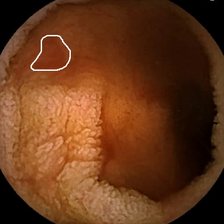

In [22]:
Image.open("/kaggle/input/testbleedyolo/Auto-WCEBleedGen Challenge Test Dataset/Test Dataset 1/" + "A0034.png")

In [10]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 7.6 MB/s eta 0:00:00a 0:00:01


In [11]:
from ultralytics import YOLO
import os
os.environ['WANDB_DISABLED'] = 'true'
# Load the model.
model = YOLO('/kaggle/input/cvip-yolo/best.pt')

In [283]:
valid_results = model.val(iou=0.6)
print(valid_results.box.map)

Ultralytics YOLOv8.0.195 🚀 Python-3.10.12 torch-2.0.0+cpu CPU (Intel Xeon 2.20GHz)
val: Scanning /kaggle/working/dataset/labels/val.cache... 262 images, 0 backgrounds, 0 corrupt: 100%|██████████| 262/262 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.39it/s]
                   all        262        262      0.725      0.653      0.704      0.413
Speed: 0.2ms preprocess, 18.1ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val5


0.41263771530088444


In [285]:
valid_results = model.val(iou=0.65)
print(valid_results.box.map)

Ultralytics YOLOv8.0.195 🚀 Python-3.10.12 torch-2.0.0+cpu CPU (Intel Xeon 2.20GHz)
val: Scanning /kaggle/working/dataset/labels/val.cache... 262 images, 0 backgrounds, 0 corrupt: 100%|██████████| 262/262 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]
                   all        262        262      0.724      0.653      0.706      0.414
Speed: 0.5ms preprocess, 23.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val7


0.4144954432345151


In [286]:
valid_results

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7de086ebae90>
fitness: 0.4436026073116444
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([     0.4145])
names: {0: 'bleeding'}
plot: True
results_dict: {'metrics/precision(B)': 0.7244216310306083, 'metrics/recall(B)': 0.6526717557251909, 'metrics/mAP50(B)': 0.7055670840058079, 'metrics/mAP50-95(B)': 0.4144954432345151, 'fitness': 0.4436026073116444}
save_dir: PosixPath('runs/detect/val7')
speed: {'preprocess': 0.4990328359239884, 'inference': 23.27688777719745, 'loss': 0.0001910988611119394, 'postprocess': 0.31974661441249697}

In [12]:
infer = model.predict(source="/kaggle/input/testbleedyolo/Auto-WCEBleedGen Challenge Test Dataset/Test Dataset 2/", conf=0.2, save_conf=True, save_txt=True, save=True) 


image 1/515 /kaggle/input/testbleedyolo/Auto-WCEBleedGen Challenge Test Dataset/Test Dataset 2/A0050.png: 224x224 (no detections), 10.4ms
image 2/515 /kaggle/input/testbleedyolo/Auto-WCEBleedGen Challenge Test Dataset/Test Dataset 2/A0051.png: 224x224 (no detections), 5.6ms
image 3/515 /kaggle/input/testbleedyolo/Auto-WCEBleedGen Challenge Test Dataset/Test Dataset 2/A0052.png: 224x224 (no detections), 5.5ms
image 4/515 /kaggle/input/testbleedyolo/Auto-WCEBleedGen Challenge Test Dataset/Test Dataset 2/A0053.png: 224x224 (no detections), 5.5ms
image 5/515 /kaggle/input/testbleedyolo/Auto-WCEBleedGen Challenge Test Dataset/Test Dataset 2/A0054.png: 224x224 (no detections), 5.4ms
image 6/515 /kaggle/input/testbleedyolo/Auto-WCEBleedGen Challenge Test Dataset/Test Dataset 2/A0055.png: 224x224 (no detections), 5.6ms
image 7/515 /kaggle/input/testbleedyolo/Auto-WCEBleedGen Challenge Test Dataset/Test Dataset 2/A0056.png: 224x224 (no detections), 5.7ms
image 8/515 /kaggle/input/testbleedyolo

In [ ]:
infer

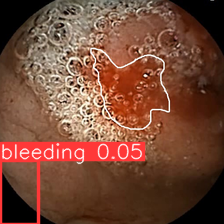

In [121]:
Image.open("runs/detect/predict/A0038.png")

In [ ]:
infer

In [13]:
import os 
testbleed2infer = sorted(os.listdir("/kaggle/input/testbleedyolo/Auto-WCEBleedGen Challenge Test Dataset/Test Dataset 2/"))
testbleed2inferdict = {}
count = 0
for a in testbleed2infer:
    try:
        with open("/kaggle/working/runs/detect/predict/labels/"+a.split(".")[0]+".txt", 'r') as f:
            temp = []
            for r in f.readlines():
                temp.append(r.split("\n")[0].split(' ')[-1])
            testbleed2inferdict[a] = max(temp)
#             print(a, [r.split("\n")[0] for r in f.readlines()], sep=', ')
            count = count+1
    except:
        continue

In [14]:
# testbleed2inferdict
testbleed2inferdictsorted = sorted(testbleed2inferdict.items(), key=lambda x:x[1], reverse=True)

In [15]:
testbleed2inferdictsorted

[('A0123.png', '0.912617'),
 ('A0375.png', '0.820615'),
 ('A0279.png', '0.746522'),
 ('A0071.png', '0.721107'),
 ('A0329.png', '0.698805'),
 ('A0081.png', '0.685299'),
 ('A0246.png', '0.684787'),
 ('A0424.png', '0.639733'),
 ('A0114.png', '0.61618'),
 ('A0067.png', '0.601629'),
 ('A0353.png', '0.582982'),
 ('A0467.png', '0.58237'),
 ('A0117.png', '0.579305'),
 ('A0330.png', '0.57366'),
 ('A0372.png', '0.561274'),
 ('A0469.png', '0.56037'),
 ('A0477.png', '0.546169'),
 ('A0397.png', '0.545235'),
 ('A0132.png', '0.542071'),
 ('A0333.png', '0.534872'),
 ('A0445.png', '0.533482'),
 ('A0450.png', '0.530968'),
 ('A0162.png', '0.528513'),
 ('A0427.png', '0.524379'),
 ('A0440.png', '0.52038'),
 ('A0121.png', '0.511225'),
 ('A0498.png', '0.50139'),
 ('A0118.png', '0.486182'),
 ('A0468.png', '0.482741'),
 ('A0360.png', '0.467463'),
 ('A0383.png', '0.464302'),
 ('A0382.png', '0.462564'),
 ('A0241.png', '0.458776'),
 ('A0283.png', '0.458776'),
 ('A0269.png', '0.44892'),
 ('A0215.png', '0.446141'),

In [253]:
sorted_dict2['A0040.png']

['bleeding', [0.9803436994552612, 0.019656337797641754]]

In [279]:
print(sorted_dict2['A0036.png'])

['bleeding', [0.9938283562660217, 0.006171696819365025]]


In [ ]:
testbleed2inferdictsorted

In [144]:
count

171

In [263]:
!rm -rf /kaggle/working/runs/detect/predict4/*

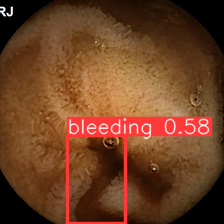

In [17]:
from PIL import Image
Image.open("/kaggle/working/runs/detect/predict/A0467.png")

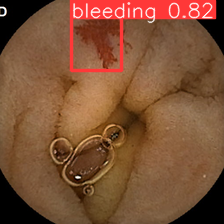

In [174]:
Image.open("/kaggle/working/runs/detect/predict2/A0375.png")

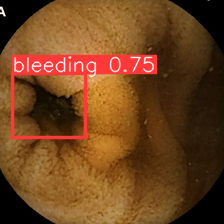

In [175]:
Image.open("/kaggle/working/runs/detect/predict2/A0279.png")

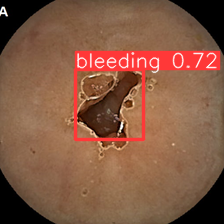

In [176]:
Image.open("/kaggle/working/runs/detect/predict2/A0071.png")

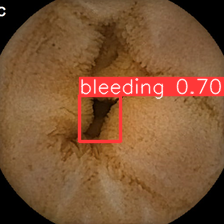

In [177]:
Image.open("/kaggle/working/runs/detect/predict2/A0329.png")

In [299]:
!ls /kaggle/working/runs/detect/val7/

F1_curve.png  confusion_matrix.png	       val_batch1_labels.jpg
PR_curve.png  confusion_matrix_normalized.png  val_batch1_pred.jpg
P_curve.png   val_batch0_labels.jpg	       val_batch2_labels.jpg
R_curve.png   val_batch0_pred.jpg	       val_batch2_pred.jpg


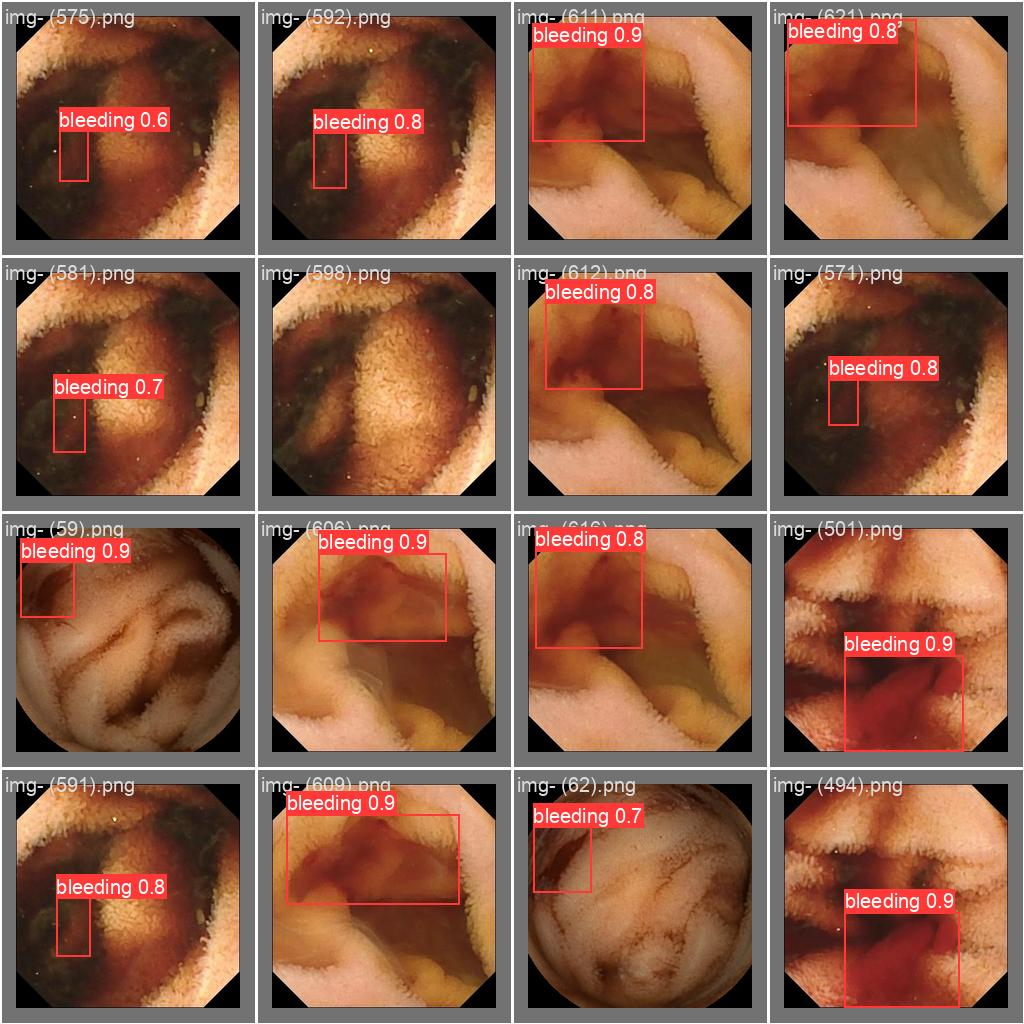

In [318]:
Image.open("/kaggle/working/runs/detect/val7/val_batch1_pred.jpg")